In [1]:
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/fhcr/task23'
drive.mount('/content/gdrive', force_remount=True)
os.chdir(gdrive_path)

print(sorted(os.listdir()))

Mounted at /content/gdrive
['dataset', 'models', 'saved_models', 'train.ipynb']


In [ ]:
!python -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchtext==0.12.0+cu113 torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
!python -m pip install numpy
!python -m pip install matplotlib

In [ ]:
!python -m pip install tqdm

In [2]:
import pickle
import numpy as np
import matplotlib
from matplotlib import pyplot as PLT

dataset_path = "dataset/combined/dataset_downsampled.pkl"

with (open(dataset_path, "rb")) as openfile:
    try:
        dataset = pickle.load(openfile)
    except Exception:
        print(Exception)

print(len(dataset['train']['rgbs']))

34822


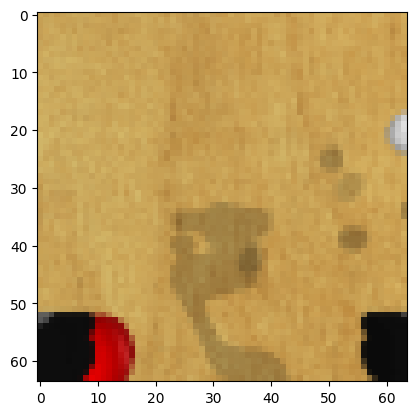

(64, 64, 3)


In [3]:
img = dataset['train']['rgbs'][0][3]
PLT.imshow(img)
PLT.show()
print(img.shape)

In [4]:
import sys
sys.path.append(gdrive_path)

In [11]:
import torch.nn as nn
import os
from models.cnn_fcn_64x64_2 import Net
import torch
import numpy as np
from torch.utils.data import TensorDataset

from torch.optim import Adam

from tqdm import tqdm

In [6]:
dataset_path = "dataset/combined/dataset_downsampled.pkl"

def saveModel(model):
    path = "saved_models/cnn_fcn_64x64_2.pth"
    torch.save(model.state_dict(), path)

def calc_val_loss(model, val_dataloader, loss_fn):

    model.eval()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            images, positions, labels = data
            images = images.to(device)
            images = images.to(torch.float32)
            labels = (labels.to(device))
            positions = (positions.to(device))
            outputs = model(x1=images, x2=positions)
            loss += loss_fn(outputs, labels).item()

    return(loss/len(val_dataloader))


def train(num_epochs, model, train_dataloader, val_dataloader, optimizer, loss_fn, patience = 10):

    best_loss = 1e8

    last_best_epoch = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    model.to(device)

    train_loss_list = []
    val_loss_list = []
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0

        for i, (images, positions, labels) in enumerate(train_dataloader, 0):
            # print(images.shape)
            # get the inputs
            images = (images.to(device))
            images = images.to(torch.float32)
            labels = (labels.to(device))
            positions = (positions.to(device))

            optimizer.zero_grad()
            outputs = model(x1= images, x2= positions)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss /= len(train_dataloader)
        train_loss_list.append(running_loss)
        print('For epoch {} the training loss is {}'.format(epoch+1, running_loss))
        running_loss = 0.0

        val_loss = calc_val_loss(model, val_dataloader, loss_fn)
        print('For epoch {} the validation loss is {}'.format(epoch+1, val_loss))
        val_loss_list.append(val_loss)
        if val_loss < best_loss:
            saveModel(model)
            best_loss = val_loss
            last_best_epoch = epoch

        if last_best_epoch and epoch-last_best_epoch>patience:
            print('stopping training because of no improvement after {} epochs in epoch {}'.format(patience, epoch+1))
            break

    return train_loss_list, val_loss_list



In [7]:


dataset["train"]["rgbs"] = np.moveaxis(dataset["train"]["rgbs"], 4, 2)
dataset["val"]["rgbs"] = np.moveaxis(dataset["val"]["rgbs"], 4, 2)

num_train_samples = dataset["train"]["rgbs"].shape[0]
num_val_samples = dataset["val"]["rgbs"].shape[0]


In [8]:
print("training with {} training samples and {} validation samples".format(num_train_samples, num_val_samples))

train_dataset = TensorDataset(torch.tensor(dataset["train"]["rgbs"], dtype=torch.uint8)
                              , torch.Tensor(dataset["train"]["joint_positions"])
                              , torch.Tensor(dataset["train"]["joint_velocities"]))
val_dataset = TensorDataset(torch.tensor(dataset["val"]["rgbs"], dtype=torch.uint8)
                              , torch.Tensor(dataset["val"]["joint_positions"])
                              , torch.Tensor(dataset["val"]["joint_velocities"]))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=50,
                                        shuffle=False, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=50,
                                        shuffle=False, num_workers=0)
del train_dataset
del val_dataset

training with 34822 training samples and 6964 validation samples


In [ ]:
model = Net()
print("number of model params:", sum(p.numel() for p in model.parameters()))

loss_fn = nn.MSELoss()
# optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = Adam(model.parameters(), lr=0.0008, weight_decay=0.0001)

In [ ]:
train_loss_list, val_loss_list = train(2, model, train_dataloader, val_dataloader, optimizer, loss_fn, patience = 40)

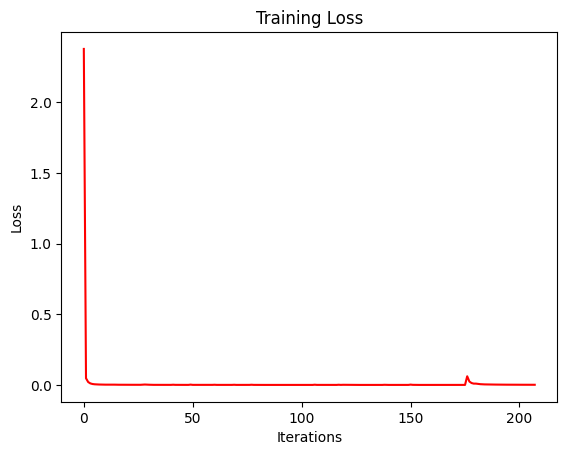

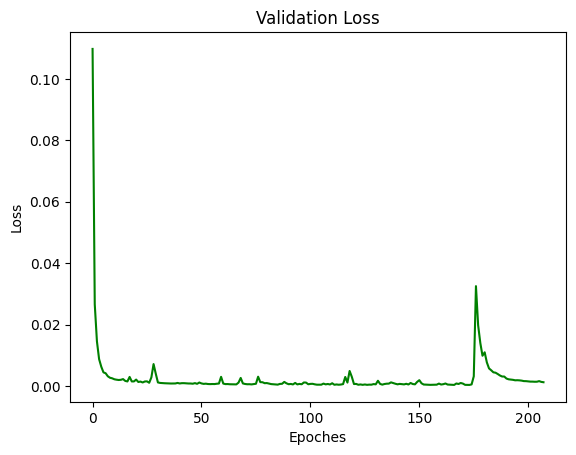

In [ ]:
fig1 = PLT.figure("train")
PLT.plot(train_loss_list, c="red")
PLT.title("Training Loss")
PLT.xlabel("Iterations")
PLT.ylabel("Loss")
fig2 = PLT.figure("val")
PLT.plot(val_loss_list, c="green")
PLT.title("Validation Loss")
PLT.xlabel("Epoches")
PLT.ylabel("Loss")
PLT.show()